In [26]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import ndimage
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.colors as pltc
from dext.postprocessing.detection_visualization import get_text_origin
import colorsys
import random

SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rc('text', usetex=True)
plt.rc('font', size=MEDIUM_SIZE) # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE, linewidth=2) # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath \usepackage{bm} \usepackage{amsmath}'

In [27]:
result_dir = '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/FasterRCNN_IntegratedGradients'
saliency_image_paths = 'saliency_image_paths'
ap_curve_linspace = 100

In [28]:
def get_history_file(result_dir, filename):
    if os.path.exists(result_dir):
        file = os.path.join(result_dir, filename)
        if os.path.exists(file):
            return file
        else:
            raise ValueError('File in directory unavailable') 
    else:
        raise ValueError('Result directory unavailable')

def get_image_index_counts(result_dir, filename):
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    data = np.array(data)
    all_image_index = list(np.unique(data[:, 0]))
    return len(all_image_index)

def get_data(result_dir, filename):
    file = get_history_file(result_dir, filename)
    data = [json.loads(line) for line in open(file, 'r')]
    return np.array(data)

In [29]:
model_saliency_paths = dict()
model_name_interpretation = (result_dir.split('/')[-1])
model_name = model_name_interpretation.split('_')[0]
interpretation_method = model_name_interpretation.split('_')[1]
print('Model name: %s | Interpretation method: %s' % (model_name, interpretation_method))
print("Number of saliency image paths: ", get_image_index_counts(result_dir, saliency_image_paths))
saliency_image_paths_data = get_data(result_dir, saliency_image_paths)

Model name: FasterRCNN | Interpretation method: IntegratedGradients
Number of saliency image paths:  20


/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/media/deepan/externaldrive1/project_repos/paz_versions/paz_efficientdet/venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [30]:
column_names = ['image_index', 'object_index', 'box', 'confidence', 'class', 'explaining',
                'boxoffset', 'saliency_path', 'image_path']

count_image_index = np.unique(saliency_image_paths_data[:, column_names.index('image_index')], return_counts=True)

data = saliency_image_paths_data[saliency_image_paths_data[:,column_names.index('image_index')] == 
                                 count_image_index[0][np.argmax(count_image_index[1])]]
data[0]

array(['386912', '0', list([212.0, 145.0, 421.0, 409.0]),
       0.979185163974762, 'person', 'Classification', None,
       '/scratch/dpadma2s/thesis/results/FasterRCNN_IntegratedGradients/saliency_images/386912_0_Classification_None_IntegratedGradients.npy',
       '/scratch/dpadma2s/coco/val2017/000000386912.jpg'], dtype=object)

In [31]:
def get_heatmaps(data):
    class_maps = []
    box_maps1 = []
    box_maps2 = []
    box_maps3 = []
    box_maps4 = []
    class_maps_boxes = []
    box_maps1_boxes = []
    box_maps2_boxes = []
    box_maps3_boxes = []
    box_maps4_boxes = []
    labels = []
    for i in data:
        if i[5] == 'Classification':
            file_path = i[-2]
            file_path = file_path.replace('/scratch/dpadma2s/thesis/results/', 
                                          '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/')
            class_maps.append(np.load(file_path))
            class_maps_boxes.append(i[2])
            labels.append(i[4])
        elif i[5] == 'Boxoffset' and i[6] == 0:
            file_path = i[-2]
            file_path = file_path.replace('/scratch/dpadma2s/thesis/results/', 
                                          '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/')
            box_maps1.append(np.load(file_path))
            box_maps1_boxes.append(i[2])
        elif i[5] == 'Boxoffset' and i[6] == 1:
            file_path = i[-2]
            file_path = file_path.replace('/scratch/dpadma2s/thesis/results/', 
                                          '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/')
            box_maps2.append(np.load(file_path))
            box_maps2_boxes.append(i[2])
        elif i[5] == 'Boxoffset' and i[6] == 2:
            file_path = i[-2]
            file_path = file_path.replace('/scratch/dpadma2s/thesis/results/', 
                                          '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/')
            box_maps3.append(np.load(file_path))
            box_maps3_boxes.append(i[2])
        elif i[5] == 'Boxoffset' and i[6] == 3:
            file_path = i[-2]
            file_path = file_path.replace('/scratch/dpadma2s/thesis/results/', 
                                          '/media/deepan/externaldrive1/project_repos/DEXT_versions/other_reports/')
            box_maps4.append(np.load(file_path))
            box_maps4_boxes.append(i[2])
    return (class_maps, class_maps_boxes, box_maps1, box_maps1_boxes, box_maps2, box_maps2_boxes, 
            box_maps3, box_maps3_boxes, box_maps4, box_maps4_boxes, labels)
    

In [32]:
(class_maps, class_maps_boxes, box_maps1, box_maps1_boxes,
box_maps2, box_maps2_boxes, box_maps3, 
box_maps3_boxes, box_maps4, box_maps4_boxes, labels) = get_heatmaps(data)

In [33]:
len(class_maps), len(box_maps1), len(box_maps1_boxes), len(labels)

(33, 33, 33, 33)

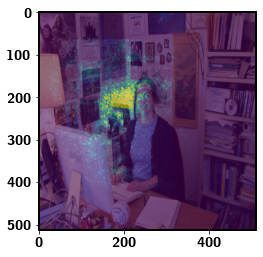

In [34]:
raw_image = cv2.imread('/media/deepan/externaldrive1/datasets_project_repos/coco/remaining_val/000000386912.jpg')
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(raw_image, (512, 512))
ex_map = class_maps[2]
ex_box = class_maps_boxes[2]
plt.imshow(ex_map)
plt.imshow(image, alpha=0.4)
plt.show()

In [35]:
def rescale_box(box, old_size, new_size):
    image_h, image_w, _ = old_size
    new_h, new_w = new_size
    x_min, y_min, x_max, y_max = box
    x_min = max(0, int((x_min / image_w) * new_w))
    y_min = max(0, int((y_min / image_h) * new_h))
    x_max = min(int((x_max / image_w) * new_w), new_w)
    y_max = min(int((y_max / image_h) * new_h), new_h)
    return x_min, y_min, x_max, y_max

In [36]:
def calculate_weighted_average(img):
    y = range(0, img.shape[0])
    x = range(0, img.shape[1])
    Y, X = np.meshgrid(y,x)
    y_coord = (Y*img).sum() / img.sum().astype("float")
    x_coord = (X*img).sum() / img.sum().astype("float")
    return np.array([x_coord, y_coord])

In [37]:
def my_covariance(ex_map):
    y = range(0, ex_map.shape[0])
    x = range(0, ex_map.shape[1])
    Y, X = np.meshgrid(y,x)
    X = X.flatten()
    Y = Y.flatten()
    value = np.vstack((X, Y))
    weight = ex_map.flatten()
    summer = calculate_weighted_average(ex_map)
    #summer1 = np.dot(value, weight) / sum(weight)
    #print(summer1)
    #summer2 = np.average(val, weights=weight, axis=1)
    #print(summer2)
    X = value.T
    C = np.multiply(X, weight[:, np.newaxis])
    C = np.sum(C, axis=0)/sum(weight)
    cov = np.dot((C - X).T, np.multiply(C - X, weight[:, np.newaxis])) / sum(weight)
    return cov

In [38]:
def calculate_covariance(ex_map):
    y = range(0, ex_map.shape[0])
    x = range(0, ex_map.shape[1])
    Y, X = np.meshgrid(y,x)
    X = X.flatten()
    Y = Y.flatten()
    value = np.vstack((X, Y))
    weight = ex_map.flatten()
    cov = np.cov(value, aweights=weight)
    return cov

In [39]:
def find_eigens(cov):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    return eigvals, eigvecs

In [40]:
def lincolor(num_colors, saturation=1, value=1, normalized=False):
    """Creates a list of RGB colors linearly sampled from HSV space with
        randomised Saturation and Value.

    # Arguments
        num_colors: Int.
        saturation: Float or `None`. If float indicates saturation.
            If `None` it samples a random value.
        value: Float or `None`. If float indicates value.
            If `None` it samples a random value.
        normalized: Bool. If True, RGB colors are returned between [0, 1]
            if False, RGB colors are between [0, 255].

    # Returns
        List, for which each element contains a list with RGB color
    """
    RGB_colors = []
    hues = [value / num_colors for value in range(0, num_colors)]
    for hue in hues:

        if saturation is None:
            saturation = 0.5

        if value is None:
            value = 0.5

        RGB_color = colorsys.hsv_to_rgb(hue, saturation, value)
        if not normalized:
            RGB_color = [int(color * 255) for color in RGB_color]
        RGB_colors.append(RGB_color)
    return RGB_colors

def plot_ellipse_opencv(ex_map, image, color):
    centroid = ndimage.measurements.center_of_mass(ex_map)
    eigvals, eigvecs = find_eigens(calculate_covariance(ex_map))
    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    theta = np.arctan2(vy, vx)
    width, height = 0.5 * np.sqrt(eigvals)
    axeslength = (int(width), int(height))
    image = cv2.ellipse(image, (int(centroid[1]), int(centroid[0])), axeslength, 
                        np.degrees(theta), 0, 360, color, 2)
    return image


def get_colors(num_colors):
    max_colors = 150
    if num_colors > max_colors:
        max_colors = num_colors
    color = lincolor(max_colors)
    random.seed(8)
    random.shuffle(color)
    jump_col = np.floor(len(color) / num_colors)
    filtered = [i for n,i in enumerate(color) if (n%jump_col==0)]
    return filtered

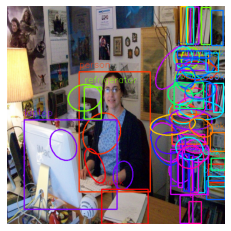

In [41]:
raw_image = cv2.imread('/media/deepan/externaldrive1/datasets_project_repos/coco/remaining_val/000000386912.jpg')
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(raw_image, (512, 512))


fig = plt.figure(frameon=False, num=1, clear=True)
ax = fig.add_subplot()
ax.set_axis_off()

colors = get_colors(len(class_maps_boxes))
num_maps = len(class_maps)
for i in range(num_maps):
    text = labels[i]
    box = rescale_box(class_maps_boxes[i], raw_image.shape, class_maps[i].shape)
    x_min, y_min, x_max, y_max = box 
    edgecolor = colors[i]
    image = plot_ellipse_opencv(class_maps[i], image, edgecolor)
    image = cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), edgecolor, 2)
    x_text, y_text = get_text_origin(image, text, 0.7, int(x_min), int(y_min), int(x_max), int(y_max))
    cv2.putText(image, text, (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.7, edgecolor, 1)           

plt.imshow(image)
plt.show()
fig.savefig('multi-decision.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
fig.clear()
plt.close(fig)
fig.clf()

https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

https://stats.stackexchange.com/questions/217374/real-meaning-of-confidence-ellipse

https://stats.stackexchange.com/questions/385475/how-to-interpret-a-given-2d-co-variance-matrix

https://www.visiondummy.com/2014/04/geometric-interpretation-covariance-matrix/

https://stats.stackexchange.com/questions/61225/correct-equation-for-weighted-unbiased-sample-covariance

https://stats.stackexchange.com/questions/361017/proper-way-of-estimating-the-covariance-error-ellipse-in-2d

https://scipython.com/book/chapter-7-matplotlib/examples/bmi-data-with-confidence-ellipses/

https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html

https://towardsdatascience.com/probability-concepts-explained-probability-distributions-introduction-part-3-4a5db81858dc

In [42]:
all_colors = [k for k,v in pltc.cnames.items()]
def get_matplotlib_colors(num_colors):
    max_colors = 150
    if num_colors > max_colors:
        max_colors = num_colors
    color = all_colors
    random.seed(8)
    random.shuffle(color)
    jump_col = np.floor(len(color) / num_colors)
    filtered = [i for n,i in enumerate(color) if (n%jump_col==0)]
    return filtered

In [43]:
def plot_explanation_ellipse(image, ex_map, edge_color='blue', ax=None, levels=1):
    if not ax:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot()
    centroid = ndimage.measurements.center_of_mass(ex_map)
    origin = [centroid[1], centroid[0]]
    
    eigvals, eigvecs = find_eigens(calculate_covariance(ex_map))
    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    theta = np.arctan2(vy, vx)
    width, height = np.sqrt(eigvals)
    for nsig in range(1, levels+1):
        e = Ellipse(xy=origin, width=nsig*width, height=nsig*height, angle=np.degrees(theta), 
                    color=edge_color, fill=None, linewidth=1, alpha=0.7)
        e.set_clip_box(ax.bbox)
        ax.add_patch(e)
    
    #plt.quiver(*origin, *eigvecs[0,:], color=edge_color, scale=15)
    #plt.quiver(*origin, *eigvecs[:, 1], color=edge_color, scale=15)
    ax.imshow(image)

In [44]:
def plot_bbox(box, edge_color, ax):
    if not ax:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot()
    x_min, y_min, x_max, y_max = box     
    rect = Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=1, edgecolor=edge_color,
                    facecolor='none', alpha=0.7, linestyle="dashed")
    ax.add_patch(rect)

In [45]:
def plot_text(text, box, edge_color, ax):
    props = dict(edgecolor='none', facecolor='none', boxstyle='square')   
    ax.text(box[0], box[1]+10, text, color='white', bbox=props, fontsize=5, clip_on=True, wrap=True)
    

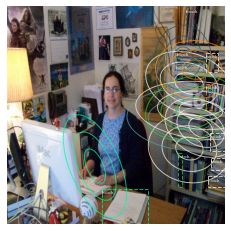

In [46]:
raw_image = cv2.imread('/media/deepan/externaldrive1/datasets_project_repos/coco/remaining_val/000000386912.jpg')
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(raw_image, (512, 512))


fig = plt.figure(frameon=False, num=1, clear=True)
ax = fig.add_subplot()
ax.set_axis_off()

colors = get_matplotlib_colors(len(class_maps_boxes))
num_maps = len(class_maps)

for i in range(20, 30): 
    edge_color = colors[i]
    box = rescale_box(class_maps_boxes[i], raw_image.shape, class_maps[i].shape)
    plot_bbox(box, edge_color, ax)
    plot_explanation_ellipse(image, class_maps[i], edge_color, ax=ax, levels=3)
    plot_text(labels[i], box, edge_color, ax)
    
fig.savefig('trial.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
fig.clear()
plt.close(fig)
fig.clf()
